In [1]:
# Imports
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

In [2]:
def rgb_to_ycbcr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

def ycbcr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)

def extract_y(img):
    return img[:, :, 0:1]  # keep channel dimension

In [3]:
def load_srcnn_dataset(lr_folder, hr_folder, lr_size=(128, 128), scale=2):
    lr_images, hr_images = [], []
    lr_files = sorted(os.listdir(lr_folder))
    hr_files = sorted(os.listdir(hr_folder))

    for lr_name, hr_name in zip(lr_files, hr_files):
        if not lr_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        # Load LR image
        lr_path = os.path.join(lr_folder, lr_name)
        lr = cv2.imread(lr_path)
        lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
        lr = cv2.resize(lr, lr_size, interpolation=cv2.INTER_CUBIC)

        # Compute HR size
        hr_size = (lr_size[0] * scale, lr_size[1] * scale)

        # Bicubic upscale the LR image
        lr_up = cv2.resize(lr, hr_size, interpolation=cv2.INTER_CUBIC)

        # Load HR ground truth
        hr_path = os.path.join(hr_folder, hr_name)
        hr = cv2.imread(hr_path)
        hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
        hr = cv2.resize(hr, hr_size, interpolation=cv2.INTER_CUBIC)

        # Convert both to YCbCr
        lr_up_ycc = rgb_to_ycbcr(lr_up) / 255.0
        hr_ycc = rgb_to_ycbcr(hr) / 255.0

        # Extract only Y channel
        lr_y = extract_y(lr_up_ycc)
        hr_y = extract_y(hr_ycc)

        lr_images.append(lr_y)
        hr_images.append(hr_y)

    return np.array(lr_images), np.array(hr_images)

In [4]:
def build_srcnn_original():
    inputs = layers.Input(shape=(None, None, 1))

    x = layers.Conv2D(64, (9, 9), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    outputs = layers.Conv2D(1, (5, 5), activation='linear', padding='same')(x)

    return models.Model(inputs, outputs)

In [7]:
lr_train_path = '/content/drive/MyDrive/dataset/train/low_res'
hr_train_path = '/content/drive/MyDrive/dataset/train/high_res'
lr_val_path = '/content/drive/MyDrive/dataset/val/low_res'
hr_val_path = '/content/drive/MyDrive/dataset/val/high_res'

In [8]:
train_lr, train_hr = load_srcnn_dataset(lr_train_path, hr_train_path)
val_lr, val_hr = load_srcnn_dataset(lr_val_path, hr_val_path)

In [9]:
model = build_srcnn_original()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, None, None, 64) │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 32) │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None, 1)  │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    train_lr, train_hr,
    validation_data=(val_lr, val_hr),
    epochs=100,
    batch_size=16
)

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 194ms/step - loss: 0.0465 - mae: 0.1385 - val_loss: 0.0062 - val_mae: 0.0459
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0050 - mae: 0.0399 - val_loss: 0.0032 - val_mae: 0.0324
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0033 - mae: 0.0347 - val_loss: 0.0026 - val_mae: 0.0285
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0024 - mae: 0.0274 - val_loss: 0.0021 - val_mae: 0.0258
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0021 - mae: 0.0267 - val_loss: 0.0018 - val_mae: 0.0249
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0018 - mae: 0.0260 - val_loss: 0.0017 - val_mae: 0.0247
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0017 - mae: 0.0246 - val_loss: 0.0016 - val_mae: 0.0236
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0016 - mae: 0.0241 - val_loss: 0.0014 - val_mae: 0.0222
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - 

In [11]:
def evaluate_on_y(model, val_lr, val_hr):
    preds = model.predict(val_lr)

    psnr_total = 0
    ssim_total = 0

    for i in range(len(preds)):
        pred = np.clip(preds[i], 0, 1).squeeze()
        hr_img = val_hr[i].squeeze()

        psnr_total += psnr(hr_img, pred, data_range=1.0)
        ssim_total += ssim(hr_img, pred, data_range=1.0)

    return psnr_total / len(preds), ssim_total / len(preds)


In [12]:
avg_psnr, avg_ssim = evaluate_on_y(model, val_lr, val_hr)
print("PSNR:", avg_psnr)
print("SSIM:", avg_ssim)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step
PSNR: 30.348413077727518
SSIM: 0.913512372088956


In [17]:
def visualize_srcnn(lr_rgb_img, hr_rgb_img, model, index=0):
    """
    lr_rgb_img: LR image upsampled to HR size (RGB, 0-255 or normalized 0-1)
    hr_rgb_img: HR ground truth (RGB)
    model: trained SRCNN model
    """
    # Ensure input in 0-1
    lr_rgb = lr_rgb_img[index]
    hr_rgb = hr_rgb_img[index]

    if lr_rgb.max() > 1.0:
        lr_rgb = lr_rgb / 255.0
    if hr_rgb.max() > 1.0:
        hr_rgb = hr_rgb / 255.0

    # Convert LR to YCrCb
    lr_ycc = rgb_to_ycbcr((lr_rgb * 255).astype(np.uint8))
    hr_ycc = rgb_to_ycbcr((hr_rgb * 255).astype(np.uint8))

    lr_y = lr_ycc[:, :, 0:1] / 255.0  # normalize
    hr_y = hr_ycc[:, :, 0:1] / 255.0

    # Predict SR Y
    pred_y = model.predict(lr_y[np.newaxis, ...])[0]
    pred_y = np.clip(pred_y, 0, 1)

    # Replace Y in LR YCrCb with SRCNN output
    sr_ycc = lr_ycc.astype(np.float32)
    sr_ycc[:, :, 0] = (pred_y[:, :, 0] * 255).astype(np.uint8)

    # Convert back to RGB
    sr_rgb = ycbcr_to_rgb(sr_ycc)

    # Plot
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(lr_rgb)
    plt.title("Bicubic Upsampled LR")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(hr_rgb)
    plt.title("Ground Truth HR")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(sr_rgb)
    plt.title("SRCNN Output")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


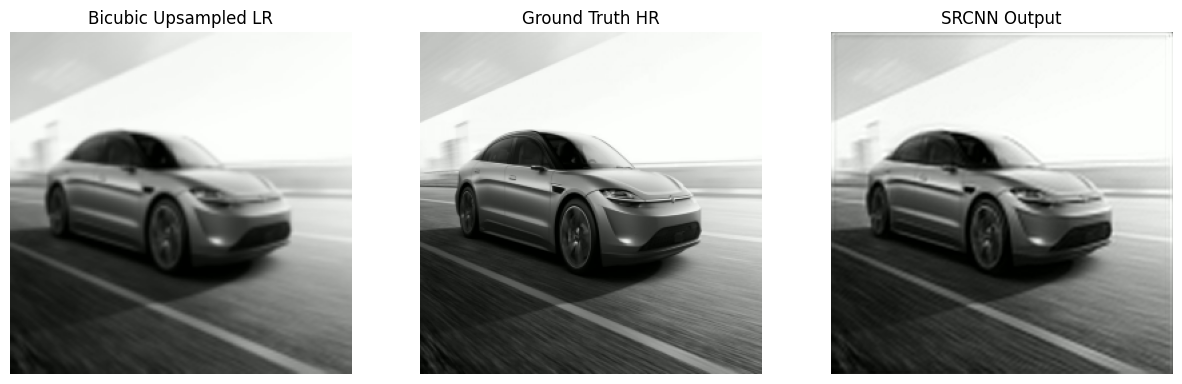

In [21]:
visualize_srcnn(val_lr, val_hr, model, index=30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


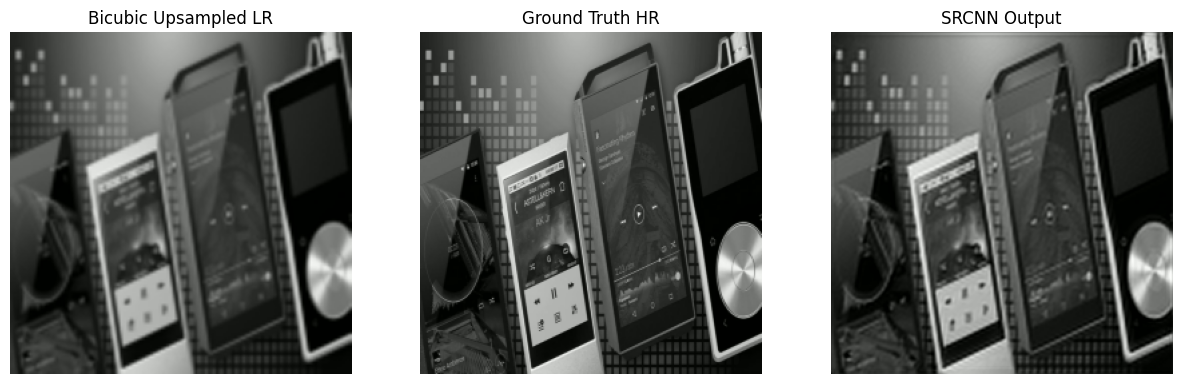

In [24]:
visualize_srcnn(val_lr, val_hr, model, index=88)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


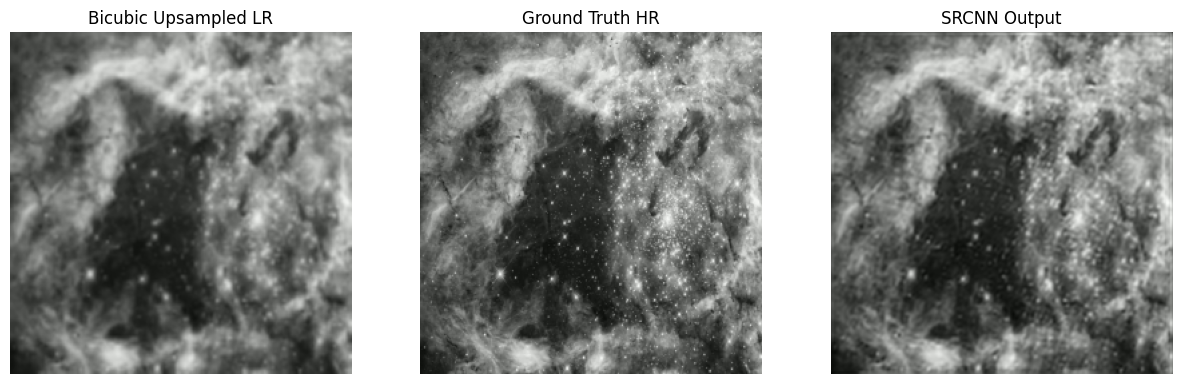

In [32]:
visualize_srcnn(val_lr, val_hr, model, index=54)